The following takes in an image and produces a depth map (which can be saved as a Torch Tensor, see comments in the main loop that iterates over a folder's images).

The main loop can only show results of applying a variety of edge operators (cell has been moved to the bottom of the notebook).

In [ ]:
!pip install opencv-python matplotlib torch torchvision torchaudio --quiet

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

midas_model_type = "DPT_Large"  # Selected to be large model
model = torch.hub.load("intel-isl/MiDaS", midas_model_type).to(device).eval()
transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transforms.dpt_transform


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:24<00:00, 56.3MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
def pred_depth(rgb):
    inp = transform(rgb).to(device)
    with torch.no_grad():
        pred = model(inp).cpu().numpy()[0]

    # Min-max scaling to 0,1
    pred = pred - pred.min()
    pred = pred / (pred.max() + 1e-8)
    return pred


In [ ]:
IMG_DIR = "/content/rgb"   # Replace with target folder
images = sorted([f for f in os.listdir(IMG_DIR)])


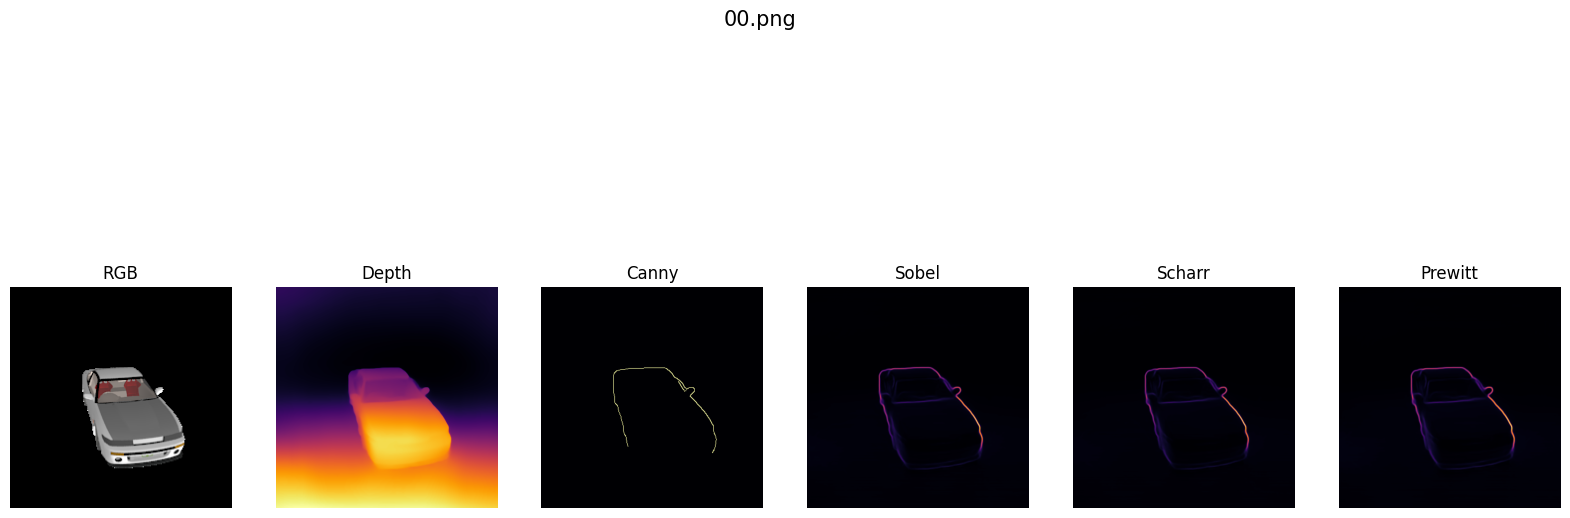

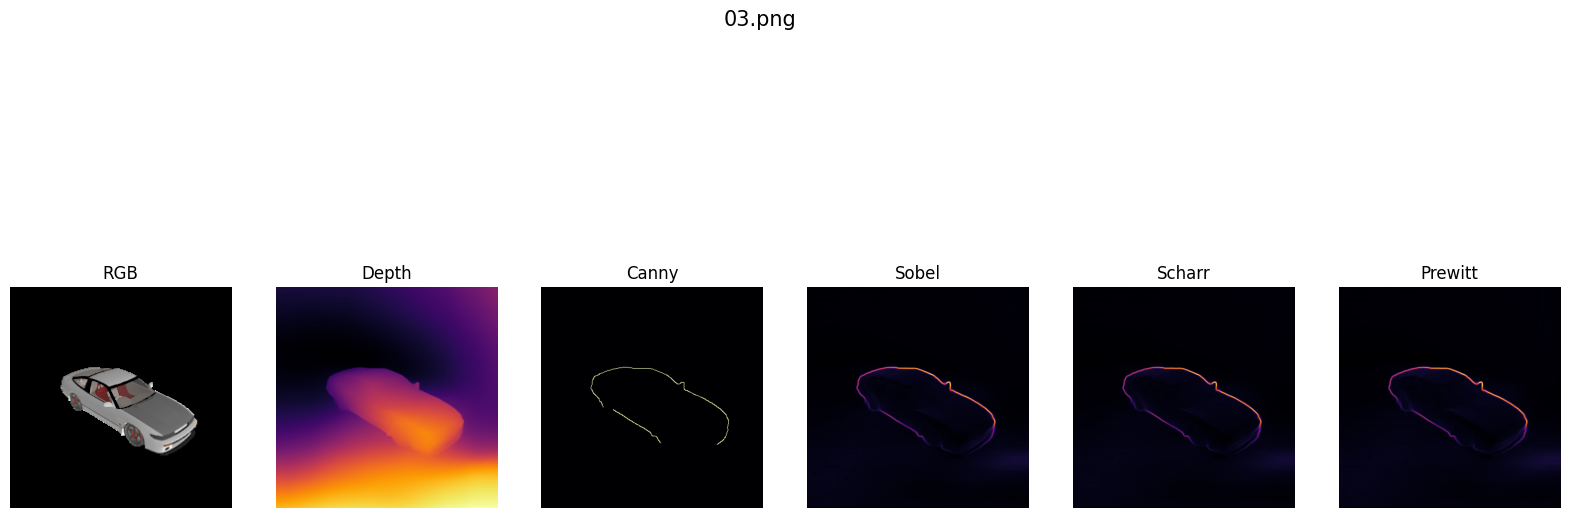

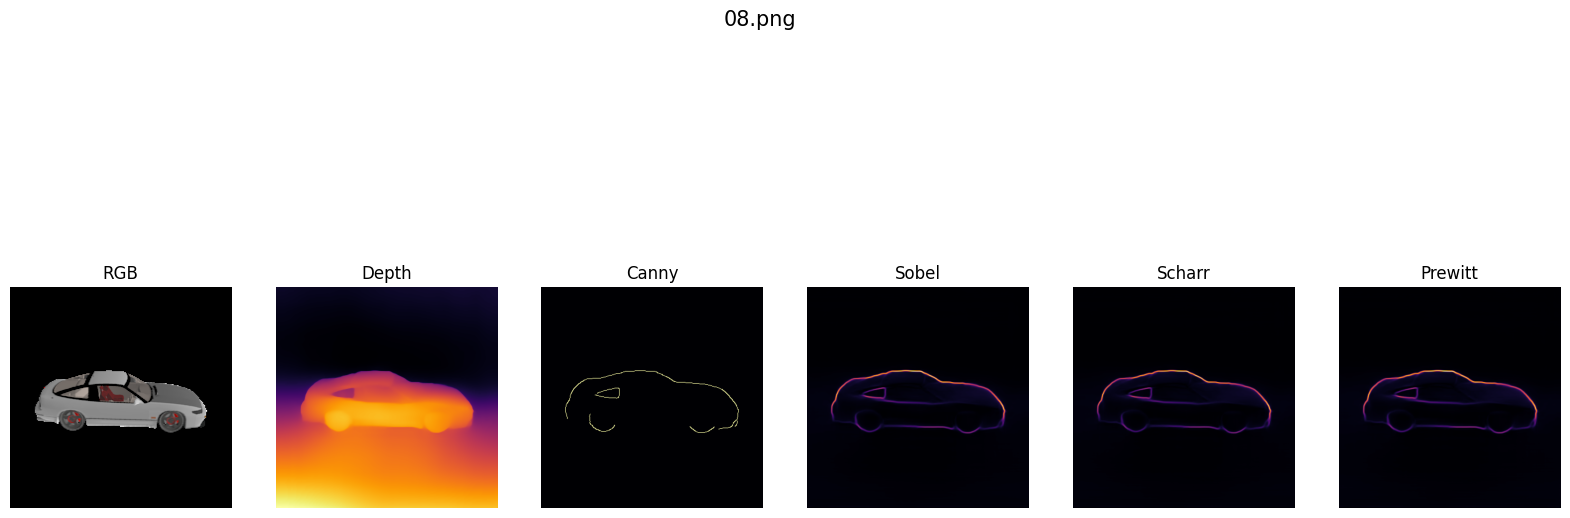

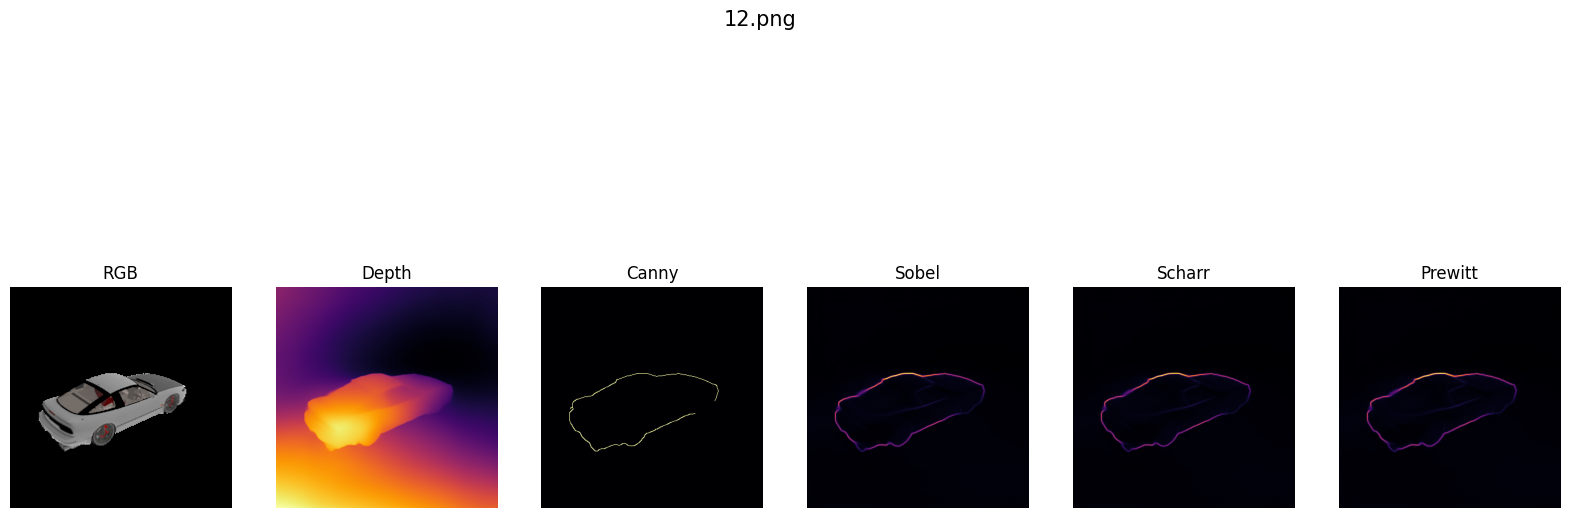

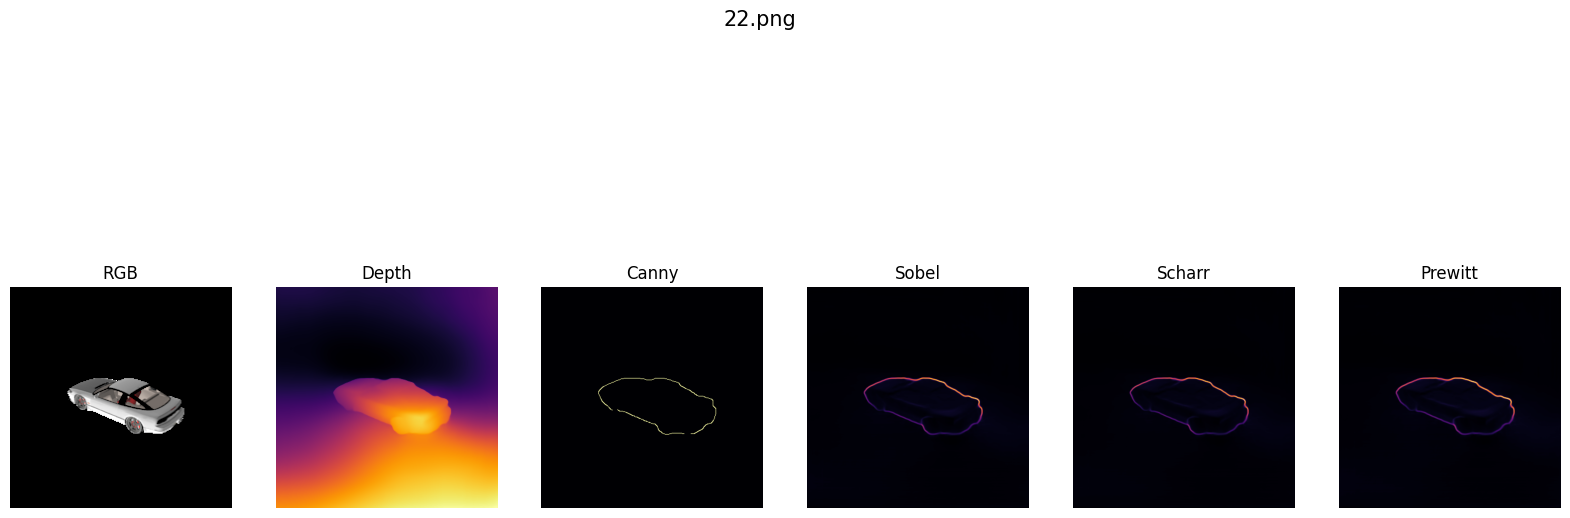

In [ ]:
for img in images:
    path = os.path.join(IMG_DIR, img)
    rgb = cv2.imread(path)[:, :, ::-1]
    depth = pred_depth(rgb) # Produce depth map array
    pred_tensor = torch.from_numpy(depth).float() # convert numpy array back to tensor
    # torch.save(pred_tensor, output_path)

    # The following is needed only if edge operator results are required
    # visualize_edges(rgb, depth, img)

## Edge Operators code.
To see (only visually) their outputs when applied to depth maps.

In [26]:
def canny_edges(depth):
    d = (depth * 255).astype(np.uint8)
    return cv2.Canny(d, 50, 150)

def sobel_edges(depth):
    dx = cv2.Sobel(depth, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(depth, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(dx*dx + dy*dy)
    return mag / (mag.max() + 1e-8)


def scharr_edges(depth):
    dx = cv2.Scharr(depth, cv2.CV_64F, 1, 0)
    dy = cv2.Scharr(depth, cv2.CV_64F, 0, 1)
    mag = np.sqrt(dx*dx + dy*dy)
    return mag / (mag.max() + 1e-8)

def prewitt_edges(depth):
    depth_64f = depth.astype(np.float64)

    kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float64)
    kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float64)


    dx = cv2.filter2D(depth_64f, -1, kernel_x) # -1 to match source and output depths
    dy = cv2.filter2D(depth_64f, -1, kernel_y)

    mag = np.sqrt(dx*dx + dy*dy)
    return mag / (mag.max() + 1e-8)


In [27]:
def visualize_edges(rgb, depth, img):
    canny = canny_edges(depth)
    sobel = sobel_edges(depth)
    scharr = scharr_edges(depth)
    prewitt = prewitt_edges(depth)

    maps = [("RGB", rgb),
        ("Depth", depth), ("Canny", canny), ("Sobel", sobel), ("Scharr", scharr), ("Prewitt", prewitt)
    ]

    plt.figure(figsize=(16, 8))
    for i, (title, m) in enumerate(maps, 1):
        plt.subplot(1, len(maps), i)
        if title == "RGB":
            plt.imshow(m)
        else:
            plt.imshow(m, cmap="inferno")
        plt.title(title)
        plt.axis("off")
    plt.suptitle(img, fontsize=12)
    plt.show()
